In [1]:
from pathlib import Path
import numpy as np

from my_types import Vec3, Quat, ScalarBatch
from my_types import as_vec3
from io_csv import load_gyro_base, load_ref, load_acc, load_grav_ref, load_acc_lin_ref
from pipelines import integrate_gyro_acc
from evaluation import calc_angle_err, print_err_status, save_err_csv, plot_err_from_csv, save_estimated_vec3_csv
from evaluation import plot_err_colored_by_weights, evaluate_estimated_vec3_autosign
from resample import find_stable_start_idx, cut_sample
from autotune import auto_setup_imu_frame, quasi_static_detector, suggest_gate_sigma, choose_tau_from_quasi_static
from Tee import Tee

SIGMA_FLOOR: float = 1e-3
EPS: float = 1e-9

In [2]:
sample_1: str = "data01_21:08_oct_07_2025_5min"
sample_2: str = "data02_21:23_oct_07_2025_9min"
sample_3: str = "data03_21:41_oct_07_2025_13min"
sample_4: str = "data04_18:52_oct_08_2025_96min"

sample: str = sample_1

root: Path = Path.cwd().parent
run_dir: Path = root / "data" / sample

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_lin_path: Path = run_dir / "Accelerometer.csv"

for p in [ori_path, gyro_path, acc_path, grav_path, acc_lin_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

out_dir: Path = root / "output" / sample
out_dir.mkdir(parents=True, exist_ok=True)

out_log: Path = out_dir / "02_exp2_log.txt"

if out_log.is_file():
        out_log.unlink()

In [3]:
with Tee(out_log):
        t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

        q_ref_interp = load_ref(ori_path, t_new)
        q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

        idx_cut: int = find_stable_start_idx(dt, w_avg_gyro, q_ref_interp,
                                        sample_window=1000, threshold=0.5, sample_hz=100,
                                        consecutive=3, min_cut_second=10, max_cut_second=30)
        t_cut: int = idx_cut / 100

        a_src_interp = load_acc(acc_path, t_new)

        dt, t_new, w_avg_gyro, q_ref_interp, a_src_interp = cut_sample(idx_cut,
                                                                [dt, t_new, w_avg_gyro, q_ref_interp, a_src_interp])



[START] 2026-02-26 20:29:12.057

[INFO] Stabilization detected too early (< min_cut), applying min_cut=10s policy

[END] 2026-02-26 20:29:12.758




In [4]:
with Tee(out_log):
        g0: float = 9.80665
        a_src_interp, g_world_unit = auto_setup_imu_frame(q_ref_interp, w_avg_gyro, dt,
                                                                g0, a_src_interp)
        print("")

        quasi_static_mask, best_quasi_static = quasi_static_detector(w_avg_gyro, a_src_interp, dt, g0,
                                                                        w_thr=4, a_thr=4,
                                                                        min_duration_s=0.5, smooth_win=5)
        print("")

        gyro_gate_sigma, acc_gate_sigma = suggest_gate_sigma(w_avg_gyro, a_src_interp, g0,
                                                                p_gyro=90, p_acc=90, sigma_floor=SIGMA_FLOOR,
                                                                best_quasi_static=best_quasi_static)



[START] 2026-02-26 20:29:12.810

Detected accel unit in [m/s²]


Selected g_world_unit: [ 0  0 -1]

Best quasi static(start, end, length):  (2523, 3540, 1017)

Suggested gyro_sigma:  0.44791971689543864
Suggested acc_sigma:  2.908568806018301

[END] 2026-02-26 20:29:13.679




In [ ]:
## exp1: without any gating

with Tee(out_log):
        q0: Quat = q_ref_interp[0].copy()
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(q0=q0, w=w_avg_gyro, dt=dt, a=a_src_interp,
                                                                g0=g0, g_world_unit=g_world_unit,
                                                                acc_gate_sigma=np.inf, gyro_gate_sigma=np.inf,
                                                                best_quasi_static=best_quasi_static,
                                                                tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3))

        print("[tau_table]")
        for i in range(3):
                print("rank", i + 1, ": [tau] ", sorted_tau_table[i]["tau"], ", [K] ", sorted_tau_table[i]["K"])
        print("")
        print("suggest tau: ", best_tau, ", K: ", K)
        print("")

        q_gyro_acc_1, g_body_est_1, a_lin_est_1, weight_acc, weight_gyro = integrate_gyro_acc(
                                                                        q0, w_avg_gyro, dt,
                                                                        K, g0, g_world_unit,
                                                                        np.inf, np.inf, a_src_interp)

        print("[choosen value]")
        print("tau=", best_tau, "K=", K)
        print("sa=inf, sg=inf")

        angle_err_gyro_acc_1: ScalarBatch = calc_angle_err(q_gyro_acc_1, q_ref_interp)
        print("")
        print_err_status("Gyro+Acc", angle_err_gyro_acc_1)



[START] 2026-02-26 20:29:13.700

[tau_table]
rank 1 : [tau]  3.0 , [K]  0.003332926432292993
rank 2 : [tau]  0.7 , [K]  0.014283970424112828
rank 3 : [tau]  1.0 , [K]  0.009998779296878979

suggest tau:  3.0 , K:  0.003332926432292993

[choosen value]
tau= 3.0 K= 0.003332926432292993
sa=inf, sg=inf

Gyro+Acc angle error in rad — min/max/mean/p90
0.0028253656890090757 1.4041137225284805 0.3414149857047015 0.5148755033035524

Gyro+Acc angle error in deg — min/max/mean/p90
0.16188152956129193 80.44979025728507 19.56163774339873 29.500193313967625

[END] 2026-02-26 20:30:02.335




In [ ]:
# exp 2-2: Gyro+Acc+Gating(Acc)

with Tee(out_log):
        q0: Quat = q_ref_interp[0].copy()
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(q0=q0, w=w_avg_gyro, dt=dt, a=a_src_interp,
                                                                g0=g0, g_world_unit=g_world_unit,
                                                                acc_gate_sigma=acc_gate_sigma, gyro_gate_sigma=np.inf,
                                                                best_quasi_static=best_quasi_static,
                                                                tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3))

        print("[tau_table]")
        for i in range(3):
                print("rank", i + 1, ": [tau] ", sorted_tau_table[i]["tau"], ", [K] ", sorted_tau_table[i]["K"])
        print("")
        print("suggest tau: ", best_tau, ", K: ", K)
        print("")

        best = None
        best_mean: float = np.inf
        acc_gate_sigma_base: float = acc_gate_sigma
        for sa in (0.01, 1, 10, np.inf): # strong → weak
                if np.isinf(sa):
                        acc_gate_sigma = np.inf
                else:
                        acc_gate_sigma = acc_gate_sigma_base * sa
                q, g_body_est, a_lin_est, weight_acc, weight_gyro = integrate_gyro_acc(
                                                                        q0, w_avg_gyro, dt,
                                                                        K, g0, g_world_unit,
                                                                        acc_gate_sigma, np.inf, a_src_interp)
                angle_err: ScalarBatch = calc_angle_err(q, q_ref_interp)
                mean_err: float = float(np.mean(angle_err))

                print(f"[sa={sa}]", f"acc_gate_sigma={acc_gate_sigma:.7f}", f"mean_err(rad)={mean_err:.7f}")

                if mean_err < best_mean:
                        best_mean = mean_err
                        best = (sa, acc_gate_sigma, q, g_body_est, a_lin_est, weight_acc, angle_err)

        best_sa, best_acc_sigma, q_gyro_acc_2, g_body_est_2, a_lin_est_2, weight_acc_2, angle_err_gyro_acc_2 = best
        print("\n")

        print("[choosen value]")
        print("tau=", best_tau, "K=", K)
        print(f"sa={best_sa}, ", f"acc_gate_sigma={best_acc_sigma:.7f}, ", "sg=inf")

        print_err_status("Gyro+Acc+Gating(Acc)", angle_err_gyro_acc_2)



[START] 2026-02-26 20:30:02.366

[tau_table]
rank 1 : [tau]  3.0 , [K]  0.003332926432292993
rank 2 : [tau]  0.7 , [K]  0.014283970424112828
rank 3 : [tau]  2.0 , [K]  0.0049993896484394895

suggest tau:  3.0 , K:  0.003332926432292993

[sa=0.01] acc_gate_sigma=0.0290857 mean_err(rad)=0.3636687
[sa=1] acc_gate_sigma=2.9085688 mean_err(rad)=0.3401973
[sa=10] acc_gate_sigma=29.0856881 mean_err(rad)=0.3413488
[sa=inf] acc_gate_sigma=inf mean_err(rad)=0.3414150


[choosen value]
tau= 3.0 K= 0.003332926432292993
sa=1,  acc_gate_sigma=2.9085688,  sg=inf
Gyro+Acc+Gating(Acc) angle error in rad — min/max/mean/p90
0.0028007213045730187 1.4022353056038215 0.3401972619552348 0.5136400057527237

Gyro+Acc+Gating(Acc) angle error in deg — min/max/mean/p90
0.16046951034440796 80.34216489533617 19.491867311941444 29.429404518706395

[END] 2026-02-26 20:31:12.561




In [ ]:
# exp 2-3: Gyro+Acc+Gating(Gyro/Acc)

with Tee(out_log):
        q0: Quat = q_ref_interp[0].copy()
        sorted_tau_table, best_tau, K = choose_tau_from_quasi_static(q0=q0, w=w_avg_gyro, dt=dt, a=a_src_interp,
                                                                g0=g0, g_world_unit=g_world_unit,
                                                                acc_gate_sigma=acc_gate_sigma, gyro_gate_sigma=gyro_gate_sigma,
                                                                best_quasi_static=best_quasi_static,
                                                                tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3))

        print("[tau_table]")
        for i in range(5):
                print("rank", i + 1, ": [tau] ", sorted_tau_table[i]["tau"], ", [K] ", sorted_tau_table[i]["K"])
        print("")
        print("suggest tau: ", best_tau, ", K: ", K)
        print("")

        best=None
        best_mean = np.inf
        gyro_gate_sigma_base: float = gyro_gate_sigma
        for sg in (0.1, 1, 10, np.inf): # strong → weak
                if np.isinf(sg):
                        gyro_gate_sigma = np.inf
                else:
                        gyro_gate_sigma = gyro_gate_sigma_base * sg
        
                q, g_body_est, a_lin_est, weight_acc, weight_gyro = integrate_gyro_acc(
                                                                        q0, w_avg_gyro, dt,
                                                                        K, g0, g_world_unit,
                                                                        best_acc_sigma, gyro_gate_sigma, a_src_interp)
                angle_err: ScalarBatch = calc_angle_err(q, q_ref_interp)
                mean_err: float = float(np.mean(angle_err))

                print(f"[sa={best_sa}]", f"acc_gate_sigma={best_acc_sigma:.7f}, ",
                f"[sg={sg}] gyro_gate_sigma={gyro_gate_sigma:.7f}, ",
                f"mean_err(rad)={mean_err:.7f}")

                if mean_err < best_mean:
                        best_mean = mean_err
                        best = (sg, gyro_gate_sigma, q, g_body_est, a_lin_est, weight_acc, weight_gyro, angle_err)

        best_sg, best_gyro_sigma, q_gyro_acc_3, g_body_est_3, a_lin_est_3, weight_acc_3, weight_gyro_3, angle_err_gyro_acc_3 = best
        print("")

        print("[choosen value]")
        print("tau=", best_tau, "K=", K)
        print(f"sa={best_sa}, ", f"acc_gate_sigma={best_acc_sigma:.7f}, ", f"sg={best_sg}, ", f"gyro_gate_sigma={best_gyro_sigma:.7f}")
        print("")

        print_err_status("Gyro+Acc+Gating(Acc)", angle_err_gyro_acc_3)



[START] 2026-02-26 20:31:12.590

[tau_table]
rank 1 : [tau]  3.0 , [K]  0.003332926432292993
rank 2 : [tau]  2.0 , [K]  0.0049993896484394895
rank 3 : [tau]  0.7 , [K]  0.014283970424112828
rank 4 : [tau]  0.5 , [K]  0.019997558593757958
rank 5 : [tau]  1.5 , [K]  0.006665852864585986

suggest tau:  3.0 , K:  0.003332926432292993

[sa=1] acc_gate_sigma=2.9085688,  [sg=0.1] gyro_gate_sigma=0.0447920,  mean_err(rad)=0.3523484
[sa=1] acc_gate_sigma=2.9085688,  [sg=1] gyro_gate_sigma=0.4479197,  mean_err(rad)=0.3390884
[sa=1] acc_gate_sigma=2.9085688,  [sg=10] gyro_gate_sigma=4.4791972,  mean_err(rad)=0.3401545
[sa=1] acc_gate_sigma=2.9085688,  [sg=inf] gyro_gate_sigma=inf,  mean_err(rad)=0.3401973

[choosen value]
tau= 3.0 K= 0.003332926432292993
sa=1,  acc_gate_sigma=2.9085688,  sg=1,  gyro_gate_sigma=0.4479197

Gyro+Acc+Gating(Acc) angle error in rad — min/max/mean/p90
0.002782597463724189 1.4018972772745735 0.33908843712552167 0.5123973023219879

Gyro+Acc+Gating(Acc) angle error in d

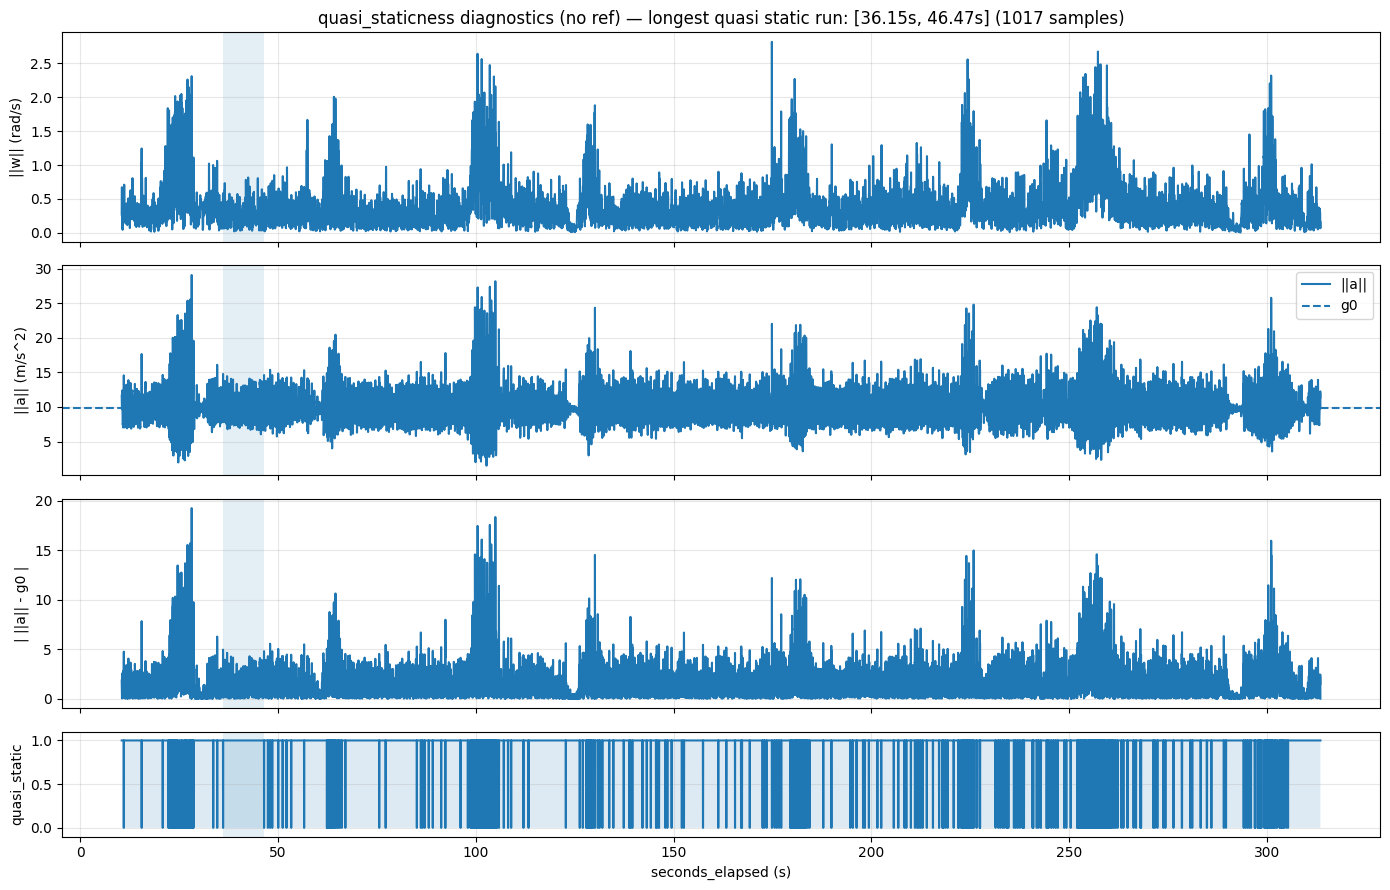

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_quasi_static_diagnostics(
    t,
    w_avg_gyro,
    a_src,
    quasi_static_mask,
    g0=9.80665,
    quasi_static_run=None,          # (start, end, len) or None
    title="quasi_staticness diagnostics (no ref)"
):
    """
    Plots:
      1) gyro norm ||w||
      2) accel norm ||a|| and g0
      3) accel residual | ||a|| - g0 |
      4) quasi_static mask (0/1)

    Also highlights the longest quasi_static run if provided.
    """
    t = np.asarray(t).reshape(-1)
    w = np.asarray(w_avg_gyro)
    a = np.asarray(a_src)
    quasi_static = np.asarray(quasi_static_mask).astype(bool)

    wn = np.linalg.norm(w, axis=1)
    an = np.linalg.norm(a, axis=1)
    acc_resid = np.abs(an - g0)

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 9), height_ratios=[2, 2, 2, 1])

    # 1) gyro norm
    axs[0].plot(t, wn)
    axs[0].set_ylabel("||w|| (rad/s)")
    axs[0].grid(True, alpha=0.3)

    # 2) accel norm
    axs[1].plot(t, an, label="||a||")
    axs[1].axhline(g0, linestyle="--", label="g0")
    axs[1].set_ylabel("||a|| (m/s^2)")
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()

    # 3) accel residual
    axs[2].plot(t, acc_resid)
    axs[2].set_ylabel("| ||a|| - g0 |")
    axs[2].grid(True, alpha=0.3)

    # 4) quasi_static mask
    axs[3].plot(t, quasi_static.astype(int))
    axs[3].set_ylabel("quasi_static")
    axs[3].set_ylim(-0.1, 1.1)
    axs[3].grid(True, alpha=0.3)
    axs[3].set_xlabel("seconds_elapsed (s)")

    # shade all quasi_static regions lightly
    # (simple approach: shade where quasi_static==True using fill_between)
    axs[3].fill_between(t, 0, 1, where=quasi_static, alpha=0.15, step="pre")

    # highlight longest run if provided
    if quasi_static_run is not None:
        s, e, _ = quasi_static_run
        t0, t1 = t[s], t[e-1]
        for ax in axs:
            ax.axvspan(t0, t1, alpha=0.12)
        axs[0].set_title(f"{title} — longest quasi static run: [{t0:.2f}s, {t1:.2f}s] ({e-s} samples)")
    else:
        axs[0].set_title(f"{title} — no quasi static run found")

    plt.tight_layout()
    plt.show()

plot_quasi_static_diagnostics(t_new, w_avg_gyro, a_src_interp, quasi_static_mask, g0=9.80665, quasi_static_run=best_quasi_static)

In [9]:
out_path_1: Path = out_dir / "02_exp2-1_angle_err_gyro_acc.csv"
out_path_2: Path = out_dir / "02_exp2-2_angle_err_gyro_acc.csv"
out_path_3: Path = out_dir / "02_exp2-3_angle_err_gyro_acc.csv"
save_err_csv(out_path_1, t_new, angle_err_gyro_acc_1)
save_err_csv(out_path_2, t_new, angle_err_gyro_acc_2)
save_err_csv(out_path_3, t_new, angle_err_gyro_acc_3)

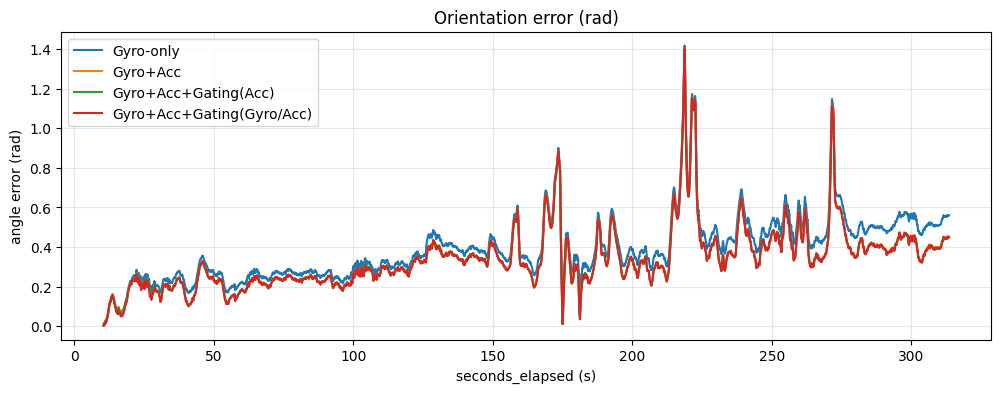

In [10]:
out_gyro_path = out_dir / "01_exp1-2_angle_err_gyro.csv"

plot_err_from_csv([
        ("Gyro-only", out_gyro_path),
        ("Gyro+Acc", out_path_1),
        ("Gyro+Acc+Gating(Acc)", out_path_2),
        ("Gyro+Acc+Gating(Gyro/Acc)", out_path_3)
])

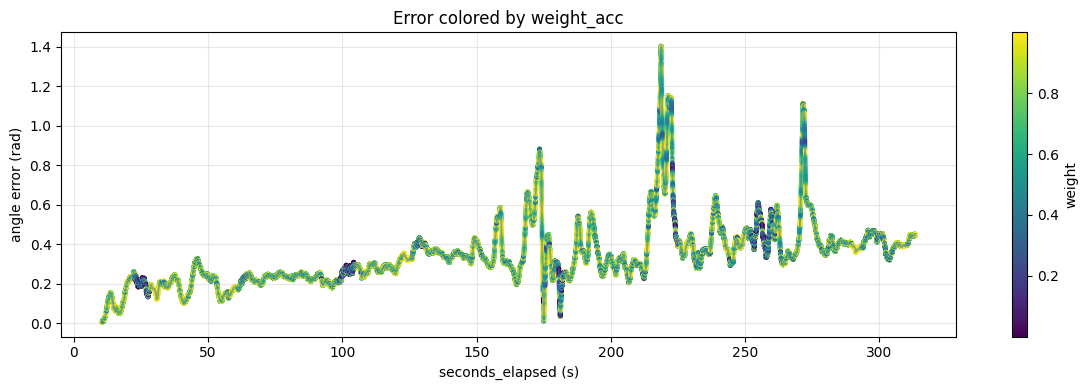

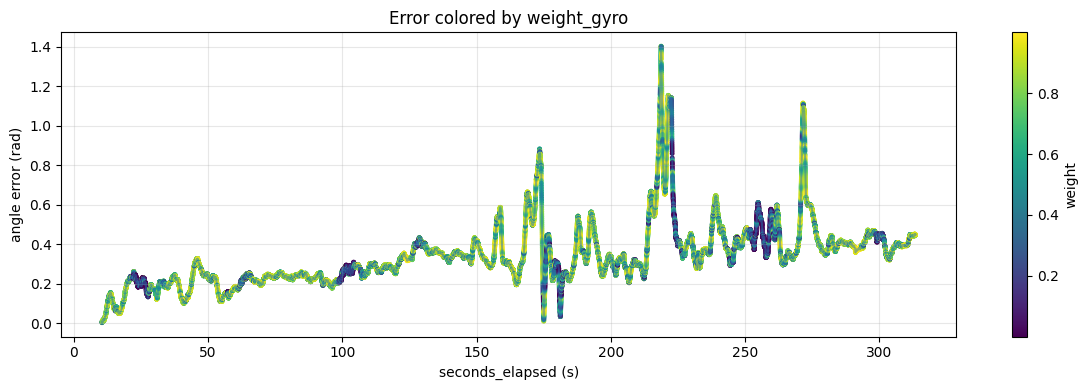

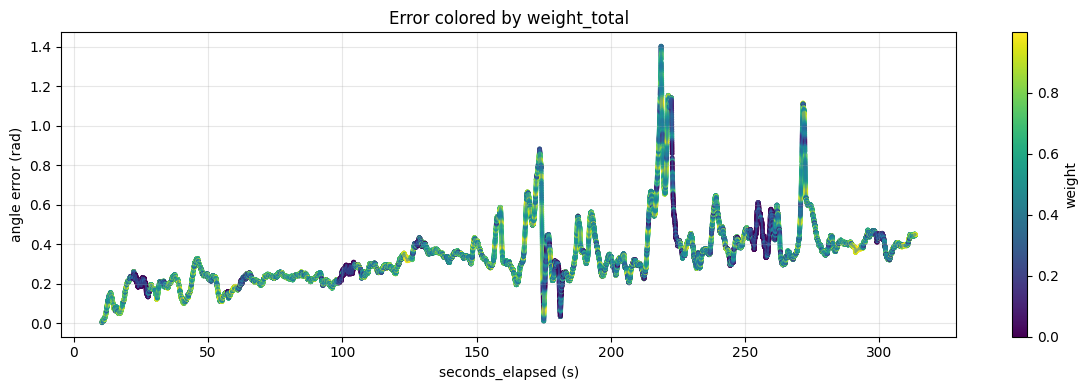

In [11]:
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_acc_3, "weight_acc")
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_gyro_3, "weight_gyro")
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_acc_3 * weight_gyro_3, "weight_total")

In [12]:
#est_dir: Path = root / "estimate"
#est_dir.mkdir(parents=True, exist_ok=True)

#print("Gravity:")
#g_ref_interp = load_grav_ref(grav_path, t_new)
#g_est_sign_fixed, g_rmse_norm = evaluate_estimated_vec3_autosign(g_body_est, g_ref_interp)
#print("")

#print("Linear Acc:")
#a_lin_ref_interp = load_acc_lin_ref(acc_lin_path, t_new)
#a_lin_est_sign_fixed, a_lin_rmse_norm = evaluate_estimated_vec3_autosign(a_lin_est, a_lin_ref_interp)
#print("")

#save_estimated_vec3_csv(est_dir / "03_gravity_estimated.csv", t_new, g_est_sign_fixed)
#save_estimated_vec3_csv(est_dir / "03_linear_acc_estimated.csv", t_new, a_lin_est_sign_fixed)

#print("consistency ratio (a_lin / g):", a_lin_rmse_norm / max(g_rmse_norm, EPS))

In [13]:
#import numpy as np

#def unit(v):
#    n = np.linalg.norm(v, axis=1, keepdims=True)
#    return v / np.maximum(n, 1e-12)

#def gravity_direction_angle_err(g_est: np.ndarray, g_ref: np.ndarray):
#    ge = unit(g_est)
#    gr = unit(g_ref)
#    c = np.sum(ge * gr, axis=1)
#    c = np.clip(c, -1.0, 1.0)
#    ang = np.arccos(c)  # rad
#    print("gravity dir angle err (rad): min/max/mean",
#          float(ang.min()), float(ang.max()), float(ang.mean()))
#    print("gravity dir angle err (deg): min/max/mean",
#          float(np.rad2deg(ang.min())), float(np.rad2deg(ang.max())), float(np.rad2deg(ang.mean())))
#    return ang

#def accel_gravity_alignment(a_src: np.ndarray, g_est: np.ndarray, g0: float, thr: float = 0.3):
#    a_norm = np.linalg.norm(a_src, axis=1)
#    mask = np.abs(a_norm - g0) < thr

#    au = unit(a_src)
#    gu = unit(g_est)
#    dot = np.sum(au * gu, axis=1)  # 부호는 플랫폼 정의에 따라 +/-1이 목표

#    d = dot[mask]
#    print(f"stationary mask count: {int(mask.sum())}/{len(mask)}")
#    print("dot(a_unit, g_unit) on stationary: mean/min/max",
#          float(np.mean(d)), float(np.min(d)), float(np.max(d)))
#    return dot, mask

#gravity_direction_angle_err(g_est_sign_fixed, g_ref_interp)
#print("=============")
#accel_gravity_alignment(a_src_interp, g_est_sign_fixed, g0)
#print("=============")